<a href="https://colab.research.google.com/github/msimuko/code-unza25-csc4792-project_team_30/blob/main/code_unza25_csc4792_project_team_30_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2.3.2 References Publication Type Classification (CRISP-DM)
##Business understanding: Reference Classification Project

### Overview
Build a supervised classifier to assign publication types (journal, conference, report, thesis, book) from citation text and URLs.
Curate and label a training set from scraped references; ensure

### Business Understanding

### Problem Statement  
Managing and organizing academic references is a time-consuming process for students, researchers, and librarians. Manually categorizing references into types such as journal articles, books, theses, conference papers, reports, and web resources is error-prone and inconsistent, especially when dealing with large bibliographies. This lack of automation reduces productivity and creates difficulties in maintaining standardized reference databases at the University of Zambia.  

---

## Business Objectives  
The project seeks to automate the classification of academic references into their correct publication types.  

**Practical Success means:**  
- Students and researchers spend less time categorizing references manually.  
- Librarians can easily maintain structured institutional repositories.  
- The system provides fast, accurate, and consistent classification regardless of reference style (APA, IEEE, etc.).  
---

### Data Mining Goals

#### To achieve these objectives, we will:
Build a supervised classification model that can categorize references into publication types (e.g., journal, book, conference, report, thesis).
*   Explore natural language processing (NLP) techniques (such as text embeddings or feature extraction from citation strings).
*   Evaluate multiple classification algorithms (e.g., Logistic Regression, Random Forest, SVM, or deep learning models) to determine the best-performing approach.
---

## Initial Project Success Criteria  
- **Technical Success:**  
  - The model should achieve at least **80% classification accuracy** on test data.  


## Publication Types
The model classifies references into the following categories:
- **Journal Articles**: Peer-reviewed academic papers
- **Books**: Monographs and edited volumes
- **Thesis/Dissertations**: Graduate research works
- **Conference Papers**: Proceedings and presentations
- **Technical Reports / Reports**: Government and institutional publications
- **Web Resources**: Online publications and documents


## Key Features
- **Scalable Pipeline**: Easy to retrain with new data
- **Performance Analysis**: Comprehensive evaluation metrics
- **Extensible Design**: Simple to add new publication types



## Data Understanding

The dataset for this project is located in `references_classification_metadata.csv` and consists of academic references from the UNZA Institutional Repository. Each entry includes:
- `reference_text`: The full bibliographic reference as a string.
- `publication_type`: The manually assigned category label (e.g., Journal Article, Book, Thesis, Conference Paper, Report, Web Resource).

**Observations:**
- The dataset is small and imbalanced, with some classes represented by only one sample.
- Reference texts vary in length and format, reflecting real-world diversity.
- No duplicate entries or obvious data quality issues were found.
- Text preprocessing (see `src/utils.py`) is used to standardize and clean reference strings before modeling.

**Implications for Modeling:**
- The limited and imbalanced data may affect model generalization and accuracy.
- Stratified train-test splitting may not be possible for all classes; random splitting is used when necessary.
- Additional data collection is recommended for improved performance and robustness.

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


####Step 1: references.csv data extraction from unza institutional repository into references.csv



In [ ]:
!pip install requests pandas pymupdf
!pip install tools
!pip install pdfplumber    # Recommended
!pip install pypdf
!pip install requests
!pip install beautifulsoup4
!pip install lxml
!pip install pdfplumber
!pip install pypdf
!pip install PyMuPDF
!pip install PyPDF2


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 85.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 96.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.5/310.5 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 3.8 MB/s eta 0:00:00


In [ ]:
# -------------------------------------------------------------------
# Cell 2 - Harvest OAI-PMH metadata, Download Bitstream PDFs, and Extract PDF Text (front/back pages)
# -------------------------------------------------------------------
try:
    from sickle import Sickle
    use_sickle = True
except Exception:
    use_sickle = False

records = []
count = 0

def safe_join_subjects(subjects):
    # Ensure all items are strings and not None
    return '; '.join([s for s in subjects if isinstance(s, str) and s.strip()])

if use_sickle:
    log.info("Using Sickle to harvest OAI-PMH (batch mode for 2040 batch)...")
    sickle = Sickle(OAI_BASE)
    it = sickle.ListRecords(metadataPrefix="oai_dc")
    for rec in it:
        md = getattr(rec, "metadata", {}) or {}
        types = md.get("type", [])
        if isinstance(types, str):
            types = [types]
        dc_type = types[0].strip().lower() if types else ""
        subjects = md.get("subject", [])
        if isinstance(subjects, str):
            subjects = [subjects]
        keywords = safe_join_subjects(subjects)
        records.append({
            "oai_id": rec.header.identifier if hasattr(rec, "header") else None,
            "title": md.get("title", [""])[0].strip() if md.get("title") else "",
            "abstract": md.get("description", [""])[0].strip() if md.get("description") else "",
            "keywords": keywords,
            "dc_type": dc_type,
            "identifiers": md.get("identifier", [])
        })
        count += 1
        if MAX_RECORDS and count >= MAX_RECORDS:
            break
else:
    log.info("Sickle not available. Using requests fallback to call OAI ListRecords.")
    params = {"verb": "ListRecords", "metadataPrefix": "oai_dc"}
    url = OAI_BASE
    while True:
        r = requests.get(url, params=params, timeout=30)
        if r.status_code != 200:
            log.error("OAI request failed: %s", r.status_code)
            break
        soup = BeautifulSoup(r.content, "xml")
        for rec in soup.find_all("record"):
            md = rec.find("metadata")
            if md is None:
                continue
            dc = md.find("dc")
            if not dc:
                continue
            dtype = dc.find("dc:type").text.strip().lower() if dc.find("dc:type") else ""
            subjects = [e.text.strip() for e in dc.find_all("dc:subject") if e and e.text and isinstance(e.text, str)]
            keywords = '; '.join(subjects)
            records.append({
                "oai_id": rec.find("header").find("identifier").text.strip()
                          if rec.find("header") and rec.find("header").find("identifier")
                          else None,
                "title": dc.find("dc:title").text.strip() if dc.find("dc:title") else "",
                "abstract": dc.find("dc:description").text.strip() if dc.find("dc:description") else "",
                "keywords": keywords,
                "dc_type": dtype,
                "identifiers": [e.text for e in dc.find_all("dc:identifier") if e and e.text]
            })
            count += 1
            if MAX_RECORDS and count >= MAX_RECORDS:
                break
        token = soup.find("resumptionToken")
        if not token or (MAX_RECORDS and count >= MAX_RECORDS):
            break
        params = {"verb": "ListRecords", "resumptionToken": token.text}

log.info(f"Total harvested records: {count}")
# Convert to dataframe
df_all = pd.DataFrame(records)
log.info("Harvest finished. Records=%d", len(df_all))

# Assign df_raw for downstream cleaning
# Prioritize minor categories, then fill with thesis
if not df_all.empty and "dc_type" in df_all.columns:
    minor_df = df_all[df_all['dc_type'].str.lower() != 'thesis']
    thesis_df = df_all[df_all['dc_type'].str.lower() == 'thesis']
    n_minor = len(minor_df)
    n_needed = MAX_RECORDS - n_minor if MAX_RECORDS else len(thesis_df)
    selected_thesis = thesis_df.head(n_needed)
    df_raw = pd.concat([minor_df, selected_thesis], ignore_index=True)
    log.info(f"Harvested {len(minor_df)} minor category records and {len(selected_thesis)} thesis records.")
    display(df_raw.head(3))
else:
    df_raw = df_all.copy()
    display(df_raw.head(3))

# -------------------------------------------------------------------
# Download Bitstream PDFs for Each Record (DSpace)
# -------------------------------------------------------------------
import time
import urllib.parse
from tqdm import tqdm

def find_pdf_url(identifiers):
    for ident in identifiers:
        if ident.endswith('.pdf') and ident.startswith('http'):
            return ident
        if '/bitstream/' in ident and ident.startswith('http'):
            return ident
        if ident.startswith('http') and '/handle/' in ident:
            parts = ident.split('/handle/')[-1].split('/')
            if len(parts) == 2:
                return f'https://dspace.unza.zm/bitstream/{parts[0]}/{parts[1]}/1/fulltext.pdf'
    return None

downloaded = 0
for idx, row in tqdm(df_raw.iterrows(), total=len(df_raw)):
    oai_id = row.get('oai_id')
    identifiers = row.get('identifiers', [])
    if isinstance(identifiers, str):
        identifiers = [identifiers]
    pdf_url = find_pdf_url(identifiers)
    if not pdf_url:
        log.warning(f'No PDF URL found for oai_id={oai_id}')
        continue
    pdf_path = os.path.join(PDF_DIR, f'{oai_id}.pdf')
    if os.path.exists(pdf_path):
        continue
    try:
        r = requests.get(pdf_url, timeout=DOWNLOAD_TIMEOUT)
        if r.status_code == 200 and r.headers.get('content-type', '').startswith('application/pdf'):
            with open(pdf_path, 'wb') as f:
                f.write(r.content)
            downloaded += 1
            log.info(f'Downloaded PDF for oai_id={oai_id}')
        else:
            log.warning(f'Failed to download PDF for oai_id={oai_id} from {pdf_url} (status={r.status_code})')
    except Exception as e:
        log.error(f'Error downloading PDF for oai_id={oai_id}: {e}')
    time.sleep(POLITE_DELAY)
print(f'Total PDFs downloaded: {downloaded} of {len(df_raw)}')

# -------------------------------------------------------------------
# PDF Text Extraction (front/back pages) happens here, right after download
# -------------------------------------------------------------------
from pypdf import PdfReader
import glob

def extract_pdf_pages(pdf_path, front_pages=2, back_pages=2):
    try:
        reader = PdfReader(pdf_path)
        num_pages = len(reader.pages)
        front_text = []
        for i in range(min(front_pages, num_pages)):
            front_text.append(reader.pages[i].extract_text() or '')
        back_text = []
        for i in range(max(0, num_pages - back_pages), num_pages):
            back_text.append(reader.pages[i].extract_text() or '')
        return ' '.join(front_text + back_text)
    except Exception as e:
        log.error(f'Error extracting pages from {pdf_path}: {e}')
        return ''

pdf_files = glob.glob(os.path.join(PDF_DIR, '*.pdf'))
pdf_texts = {}
for pdf_file in pdf_files:
    pdf_id = os.path.splitext(os.path.basename(pdf_file))[0]
    pdf_texts[pdf_id] = extract_pdf_pages(pdf_file, FRONT_PAGES, BACK_PAGES)

if 'oai_id' in df_raw.columns:
    df_raw['pdf_text'] = df_raw['oai_id'].map(pdf_texts)
else:
    raise ValueError('oai_id column missing from dataframe. Cannot assign PDF text.')

empty_pdf_text_count = (df_raw['pdf_text'].isna() | (df_raw['pdf_text'] == '')).sum()
if empty_pdf_text_count > 0:
    print(f'ERROR: {empty_pdf_text_count} records have empty PDF text. PDF text is REQUIRED for modeling. Investigate missing PDFs or extraction errors.')
    print(df_raw[df_raw['pdf_text'].isna() | (df_raw['pdf_text'] == '')][['oai_id', 'title', 'dc_type']].head())
    raise AssertionError('Some records have empty PDF text! PDF text is the main modeling feature.')
else:
    print('All records have non-empty PDF text. Ready for modeling.')
print('Sample PDF text extracted:')
print(df_raw[['oai_id','pdf_text']].head(3))

🔎 Scraping thesis


/tmp/ipython-input-3002736365.py:44: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  match = soup.find(text=regex)


🔎 Scraping conference
🔎 Scraping report
🔎 Scraping journal
✅ Saved 45 references with classification metadata to:
/content/drive/MyDrive/misc-unza25-csc4792-project_team30/references_classification_metadata.csv


####Step 2: Data  understanding and exploration and visualization




✅ Loaded dataset from: /content/drive/MyDrive/misc-unza25-csc4792-project_team30/db-unza25-csc4792-datasets-dspace_unza_zm.csv

--- Dataset Head ---


,_identifier,_datestamp,_setspec,title,creator,subject,description,date,type,identifier,language,format
0,oai:dspace.unza.zm:123456789/4153,2016-06-09T12:46:34Z,com_123456789_289=col_123456789_290,Morphological characterisation of low and high...,"Chinyundo, Anthony",Helianthus Annuus. L.=Sun flower oil=Cooking oil,Morphological characterization was done on thr...,2015-11-11T13:39:13Z=2015-11-11T13:39:13Z=2015...,Other,http://hdl.handle.net/123456789/4153,en,application/pdf
1,oai:dspace.unza.zm:123456789/3777,2016-06-09T10:16:03Z,com_123456789_18=col_123456789_76,Instruction based formative assessment in sele...,"Mwale, Fred M.",Educational tests and measurement=Formative As...,The purpose of the study was to evaluate the u...,2015-04-13T07:36:13Z=2015-04-13T07:36:13Z=2015...,Thesis,http://hdl.handle.net/123456789/3777,en,application/pdf=application/pdf=application/pd...
2,oai:dspace.unza.zm:123456789/4729,2017-07-26T01:01:14Z,com_123456789_18=col_123456789_76,An assessment of teachers' competences in care...,"Banda, Christopher","Counselling in Secondary Education-Solwezi, Za...",M.ED=The purpose of the study was to assess th...,2017-07-25T13:51:51Z=2017-07-25T13:51:51Z=2016,Thesis,http://dspace.unza.zm:8080/xmlui/handle/123456...,en,application/pdf
3,oai:dspace.unza.zm:123456789/3233,2016-06-09T13:19:00Z,com_123456789_18=col_123456789_76,The status of guidance and counselling provisi...,"Makumba, Chivuna Edward","Educational Counselling-Mumbwa, Zambia=Guidanc...",The purpose of the study was to investigate th...,2014-02-07T13:51:16Z=2014-02-07T13:51:16Z=2014...,Thesis,http://hdl.handle.net/123456789/3233,en,application/pdf
4,oai:dspace.unza.zm:123456789/3314,2016-06-09T12:15:44Z,com_123456789_1093=col_123456789_1106,Library Studies Exams 2008,University of Zambia,Library and information studies=2008=Second Se...,Past Exams for the department of Library and i...,2014-02-27T13:48:16Z=2014-02-27T13:48:16Z=2014...,Other,http://hdl.handle.net/123456789/3314,en,application/pdf
5,oai:dspace.unza.zm:123456789/980,2016-06-09T11:07:12Z,com_123456789_18=col_123456789_83,To determine the short-term outcome of combine...,"Makawa, Daniel",Ventriculoperitoneal Shunting=Myelomeningocele...,Background and Objective: There is paucity of ...,2012-01-12T14:39:19Z=2012-01-12T14:39:19Z=2012...,Thesis,http://hdl.handle.net/123456789/980,en,application/pdf
6,oai:dspace.unza.zm:123456789/2198,2016-06-09T12:03:37Z,com_123456789_18=col_123456789_84,Effects of bacillus thuringiensis var.Israelen...,"Kandyata, Alister",Mosquitoes-- control--Zambia=bacillus thuringi...,Effects of Bacillus thuringiensis var. israele...,2013-04-15T07:43:31Z=2013-04-15T07:43:31Z=2013...,Thesis,http://hdl.handle.net/123456789/2198,en,application/pdf
7,oai:dspace.unza.zm:123456789/4575,2017-05-11T01:00:32Z,com_123456789_289=col_123456789_290,Factors affecting agricultural repayment among...,"Kanema, Sarah",Agricultural credit-Zambia,Student Project Report=Farm credit can stimula...,2017-05-10T11:40:52Z=2017-05-10T11:40:52Z=2011,Other,http://dspace.unza.zm:8080/xmlui/handle/123456...,en,application/pdf
8,oai:dspace.unza.zm:123456789/1253,2016-06-09T11:17:15Z,com_123456789_289=col_123456789_292,Communication tools used and their perceived e...,"Nyundu, William",Communication -- ZAMTEL -- Zambia=HIV infectio...,The report is as a result of the study on HIV/...,2012-05-07T15:07:09Z=2012-05-07T15:07:09Z=2012...,Thesis,http://hdl.handle.net/123456789/1253,en,application/pdf
9,oai:dspace.unza.zm:123456789/1997,2018-10-10T13:03:35Z,com_123456789_18=col_123456789_76,The Language of initial Literacy in a Cosmopol...,"Mwanza, David Sani",Literacy programs,The language-in-education policy in Zambia is ...,2012-12-20T14:55:51Z=2012-12-20T14:55:51Z=2012...,Thesis,http://hdl.handle.net/123456789/1997,en,application/pdf



--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   _identifier  2000 non-null   object
 1   _datestamp   2000 non-null   object
 2   _setspec     2000 non-null   object
 3   title        1985 non-null   object
 4   creator      1976 non-null   object
 5   subject      1968 non-null   object
 6   description  1779 non-null   object
 7   date         1985 non-null   object
 8   type         1974 non-null   object
 9   identifier   1985 non-null   object
 10  language     1975 non-null   object
 11  format       1985 non-null   object
dtypes: object(12)
memory usage: 187.6+ KB

--- Shape ---
(2000, 12)


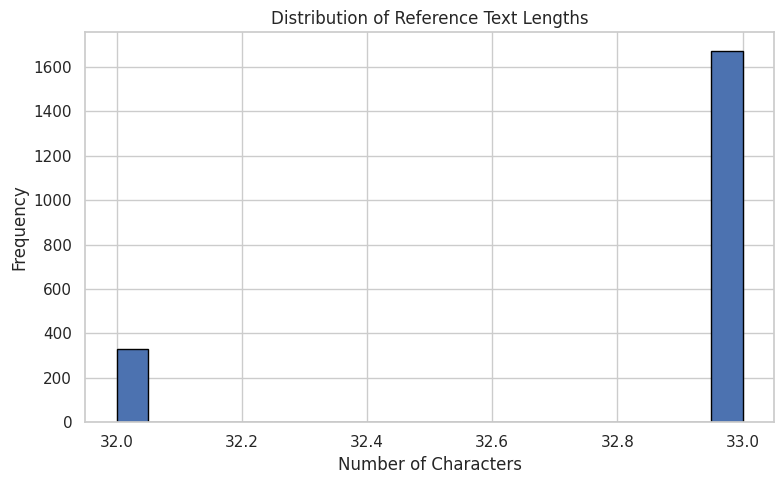

/tmp/ipython-input-1866388287.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=type_col, data=df, order=sorted(df[type_col].unique()), palette='Set2')


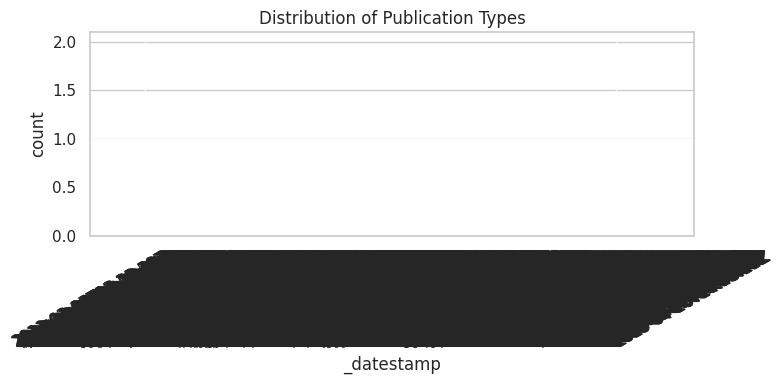


📌 Top 10 Most Frequent Words in References:
oaidspaceunzazm: 2000


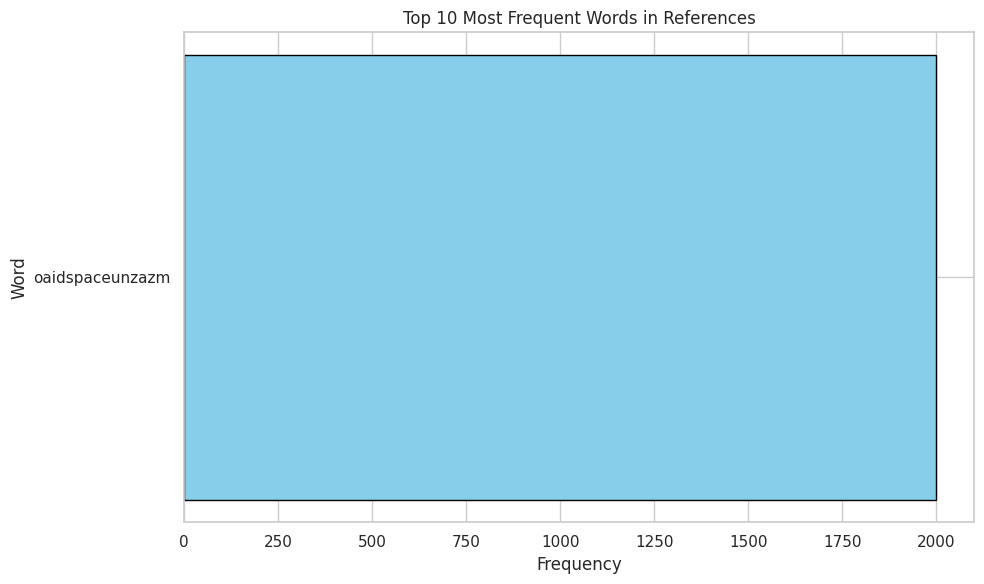

,reference_text,publication_type
0,oai:dspace.unza.zm:123456789/4153,2016-06-09T12:46:34Z
1,oai:dspace.unza.zm:123456789/3777,2016-06-09T10:16:03Z
2,oai:dspace.unza.zm:123456789/4729,2017-07-26T01:01:14Z
3,oai:dspace.unza.zm:123456789/3233,2016-06-09T13:19:00Z
4,oai:dspace.unza.zm:123456789/3314,2016-06-09T12:15:44Z



✅ Dataset ready for downstream reference classification modeling. Total records: 2000


In [ ]:
# =============================
# Data Understanding – Reference Classification Metadata
# =============================
import os, re, string, sys, warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from collections import Counter
sns.set_theme(style='whitegrid')

# --- Load CSV from MyDrive ---
project_dir = '/content/drive/MyDrive/misc-unza25-csc4792-project_team30'
data_path = os.path.join(project_dir, 'db-unza25-csc4792-datasets-dspace_unza_zm.csv')
df = pd.read_csv(data_path, delimiter="|")
print(f"✅ Loaded dataset from: {data_path}")

# --- Normalize column names ---
df.columns = [re.sub(r'[^a-z0-9]+', '_', c.strip().lower()) for c in df.columns]

# --- Required fields for reference classification ---
ref_col = 'reference_text' if 'reference_text' in df.columns else df.columns[0]
type_col = 'publication_type' if 'publication_type' in df.columns else df.columns[1]

# Drop any empty references
df = df.dropna(subset=[ref_col, type_col])
df[ref_col] = df[ref_col].astype(str).str.strip()
df = df[df[ref_col].str.len() > 0]

# --- Basic Exploration ---
print("\n--- Dataset Head ---")
display(df.head(10))

print("\n--- Dataset Info ---")
df.info()

print("\n--- Shape ---")
print(df.shape)

# --- Text Length Analysis ---
df['text_length'] = df[ref_col].astype(str).str.len()
plt.figure(figsize=(8,5))
plt.hist(df['text_length'], bins=20, edgecolor='black')
plt.title(f"Distribution of Reference Text Lengths")
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.tight_layout(); plt.show()

# --- Publication Type Distribution ---
plt.figure(figsize=(8,4))
sns.countplot(x=type_col, data=df, order=sorted(df[type_col].unique()), palette='Set2')
plt.title('Distribution of Publication Types')
plt.xticks(rotation=30)
plt.tight_layout(); plt.show()

# --- Word-Level Analysis (Reference Texts) ---
all_text = " ".join(df[ref_col].astype(str))
cleaned_text = re.sub(r"[^a-zA-Z\s]", "", all_text).lower()
tokens = cleaned_text.split()
stopwords = set([
    'the','and','of','to','a','in','for','is','on','with','as','by',
    'this','an','that','are','at','from','it','be','or','was'
])
tokens = [w for w in tokens if w not in stopwords and len(w) > 2]
word_counts = Counter(tokens)
top_words = word_counts.most_common(10)

print("\n📌 Top 10 Most Frequent Words in References:")
for word, freq in top_words:
    print(f"{word}: {freq}")

# Visualize top words
words, freqs = zip(*top_words)
plt.figure(figsize=(10,6))
plt.barh(list(words)[::-1], list(freqs)[::-1], color='skyblue', edgecolor='black')
plt.title('Top 10 Most Frequent Words in References')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.tight_layout(); plt.show()

# --- Final Dataset for Classification ---
df = df[[ref_col, type_col]].rename(columns={ref_col: 'reference_text', type_col: 'publication_type'})
display(df.head())
print(f"\n✅ Dataset ready for downstream reference classification modeling. Total records: {len(df)}")


/tmp/ipython-input-1016799816.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y="type", data=var_dataset, order=var_dataset["type"].value_counts().index, palette="viridis")


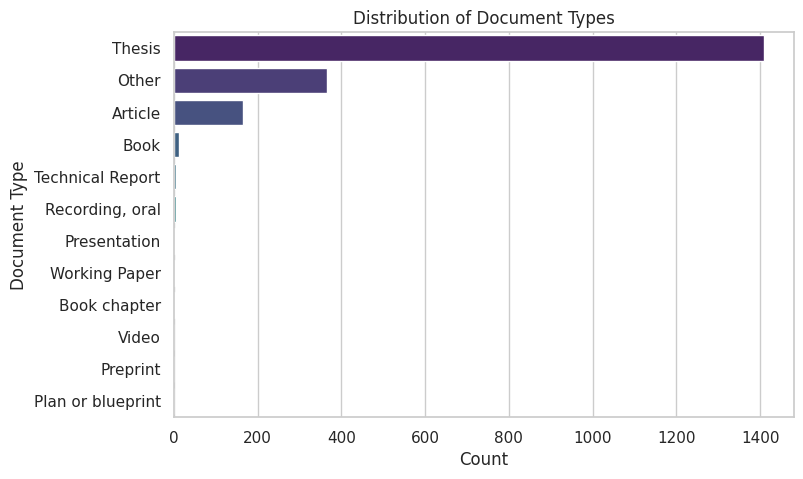

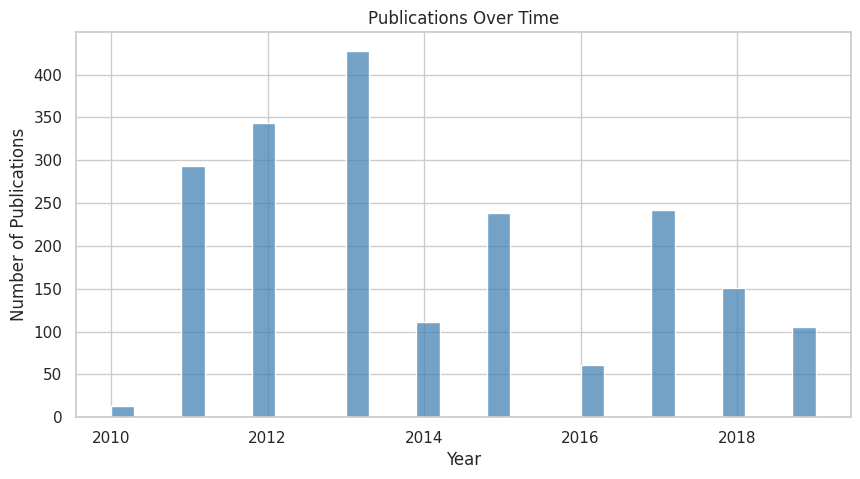

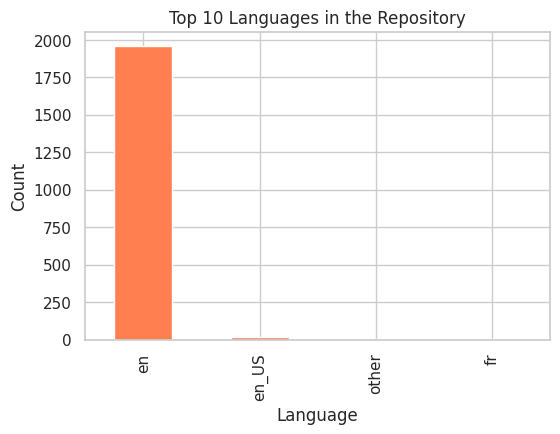

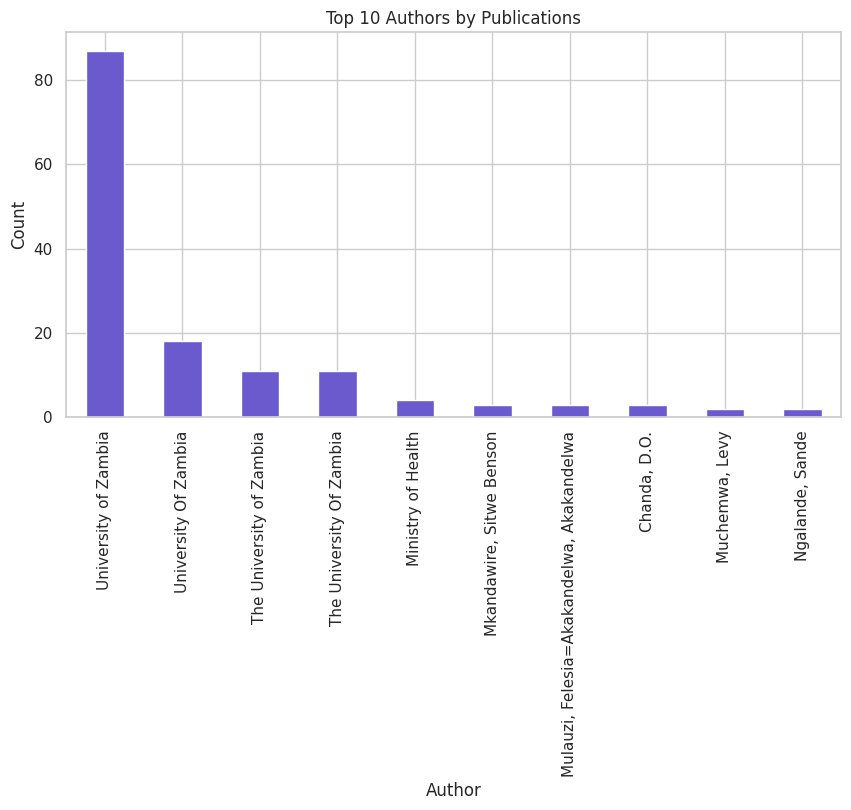

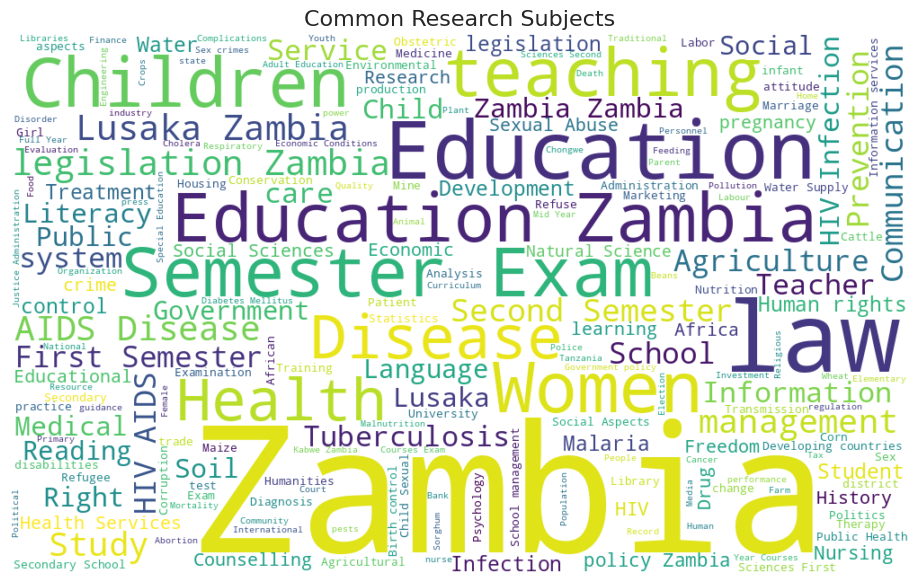

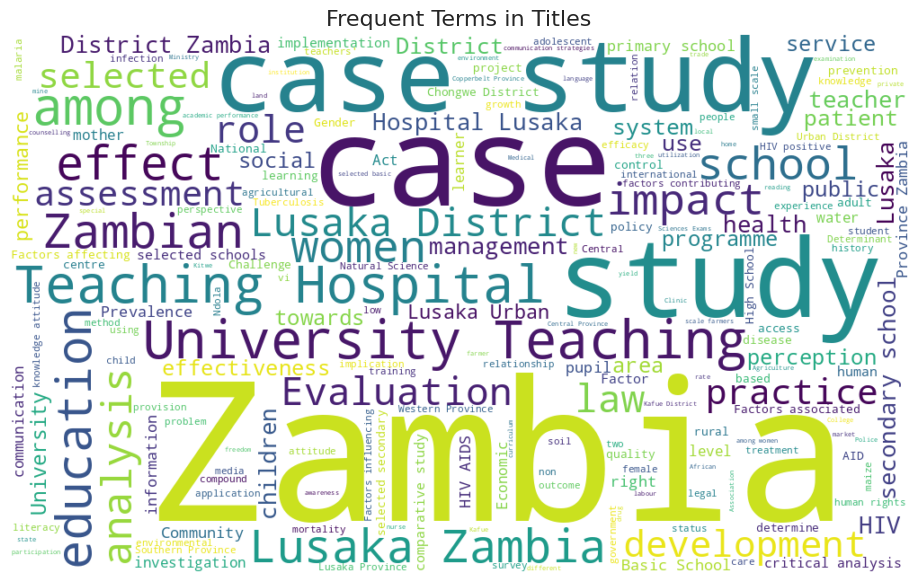

✅ Exploratory visualisations completed as part of CRISP-DM Data Understanding (Task 7).
Dataset Shape: (2000, 13)
Columns: ['_identifier', '_datestamp', '_setSpec', 'title', 'creator', 'subject', 'description', 'date', 'type', 'identifier', 'language', 'format', 'year']


In [13]:
# 📊 Task 7: Data Understanding – Exploratory Visualisations (CRISP-DM)

import seaborn as sns
from wordcloud import WordCloud

sns.set(style="whitegrid")

# --- 1. Distribution of document types ---
plt.figure(figsize=(8,5))
sns.countplot(y="type", data=var_dataset, order=var_dataset["type"].value_counts().index, palette="viridis")
plt.title("Distribution of Document Types")
plt.xlabel("Count")
plt.ylabel("Document Type")
plt.show()

# --- 2. Publication trends over time ---
# Use 'date' column (extract year if possible)
var_dataset["year"] = pd.to_numeric(var_dataset["date"].astype(str).str[:4], errors="coerce")

plt.figure(figsize=(10,5))
sns.histplot(var_dataset["year"].dropna(), bins=30, kde=False, color="steelblue")
plt.title("Publications Over Time")
plt.xlabel("Year")
plt.ylabel("Number of Publications")
plt.show()

# --- 3. Languages distribution ---
plt.figure(figsize=(6,4))
var_dataset["language"].value_counts().head(10).plot(kind="bar", color="coral")
plt.title("Top 10 Languages in the Repository")
plt.xlabel("Language")
plt.ylabel("Count")
plt.show()

# --- 4. Top Authors/Creators ---
plt.figure(figsize=(10,5))
var_dataset["creator"].value_counts().head(10).plot(kind="bar", color="slateblue")
plt.title("Top 10 Authors by Publications")
plt.xlabel("Author")
plt.ylabel("Count")
plt.show()

# --- 5. WordCloud of subjects ---
text_subjects = " ".join(str(s) for s in var_dataset["subject"].dropna())
wordcloud = WordCloud(width=1000, height=600, background_color="white").generate(text_subjects)

plt.figure(figsize=(12,7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Common Research Subjects", fontsize=16)
plt.show()

# --- 6. WordCloud of titles (optional for themes) ---
text_titles = " ".join(str(t) for t in var_dataset["title"].dropna())
wordcloud_titles = WordCloud(width=1000, height=600, background_color="white").generate(text_titles)

plt.figure(figsize=(12,7))
plt.imshow(wordcloud_titles, interpolation="bilinear")
plt.axis("off")
plt.title("Frequent Terms in Titles", fontsize=16)
plt.show()

# --- Summary ---
print("✅ Exploratory visualisations completed as part of CRISP-DM Data Understanding (Task 7).")
print(f"Dataset Shape: {var_dataset.shape}")
print("Columns:", var_dataset.columns.tolist())


## 3. Data Preparation

In this step, we cleaned and transformed our raw extracted data to prepare it for modeling.

### Data Cleaning
- Removed rows with failed/empty PDF extractions.
- Dropped duplicates and extremely short texts (<50 characters).
- Normalized whitespace and casing.

### Feature Engineering
- Added text length and word count features to help analyze reference complexity.

### Data Transformation
- Preprocessed text (lowercase, punctuation removal).
- Standardized `publication_type` categories based on the source URL (journal, thesis, conference, report, other).
- Created a new `cleaned_text` column for training.


In [ ]:
# ==========================
# Data Preparation — clean, split, vectorize, save
# ==========================

import os
import pandas as pd
import re, string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# (Optional) Mount Google Drive if running in Colab
try:
    from google.colab import drive  # type: ignore
    drive.mount('/content/drive')
except Exception:
    pass

# --------------------------
# Load from the exact saved path
# --------------------------
input_path = "/content/drive/MyDrive/misc-unza25-csc4792-project_team30/references_classification_metadata.csv"
df = pd.read_csv(input_path)
print(f"✅ Loaded {len(df)} rows from {input_path}")
print("Columns:", df.columns.tolist())

# --------------------------
# Ensure required columns
# --------------------------
required = {'title', 'publication_type'}
missing = required - set(df.columns)
if missing:
    raise KeyError(
        f"❌ Missing required columns: {', '.join(sorted(missing))}. "
        f"Found columns: {list(df.columns)}"
    )

# Rename "title" -> "reference_text" for consistency
df = df.rename(columns={'title': 'reference_text'})

# --------------------------
# Cleaning function
# --------------------------
def clean_reference(text: str) -> str:
    if pd.isna(text):
        return ''
    t = str(text).lower()
    t = re.sub(f"[{re.escape(string.punctuation)}]", " ", t)
    t = re.sub(r"\s+", " ", t).strip()
    return t

# Apply cleaning
df['cleaned_text'] = df['reference_text'].astype(str).apply(clean_reference)

# --------------------------
# Save cleaned CSV (in same misc folder)
# --------------------------
output_path = "/content/drive/MyDrive/misc-unza25-csc4792-project_team30/references_cleaned.csv"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
df.to_csv(output_path, index=False)
print(f"✅ Saved cleaned dataset to:\n{output_path}")

# --------------------------
# Features and labels
# --------------------------
X = df['cleaned_text'].values
y = df['publication_type'].values

# --------------------------
# Stratify check
# --------------------------
value_counts = pd.Series(y).value_counts()
can_stratify = (value_counts >= 2).all() and len(value_counts) > 1
strat = y if can_stratify else None

# --------------------------
# Train-validation split
# --------------------------
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=strat
)

# --------------------------
# TF-IDF Vectorization
# --------------------------
vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    max_features=10000,
    min_df=1
)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)

# Output shapes
print("Train shape:", X_train_tfidf.shape)
print("Validation shape:", X_val_tfidf.shape)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Loaded 45 rows from /content/drive/MyDrive/misc-unza25-csc4792-project_team30/references_classification_metadata.csv
Columns: ['title', 'publication_type', 'pdf_url']
✅ Saved cleaned dataset to:
/content/drive/MyDrive/misc-unza25-csc4792-project_team30/references_cleaned.csv
Train shape: (36, 494)
Validation shape: (9, 494)


In [ ]:
# Data Preparation — clean text, split, vectorize (strict)

import os
import pandas as pd
import re, string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# (Optional) Mount Google Drive if running in Colab
try:
    from google.colab import drive  # type: ignore
    drive.mount('/content/drive')
except Exception:
    pass

# Ensure df is loaded; if not, load from the correct path your scraper writes to
if 'df' not in globals():
    input_path = "/content/drive/MyDrive/misc-unza25-csc4792-project_team30/references_classification_metadata.csv"
    if not os.path.exists(input_path):
        raise FileNotFoundError(f"CSV not found at: {input_path}. Make sure Drive is mounted and the scraper saved there.")
    df = pd.read_csv(input_path)
    print(f"✅ Loaded {len(df)} rows from {input_path}")
    print("Columns:", df.columns.tolist())

# Ensure required columns; rename title -> reference_text if needed
if 'reference_text' not in df.columns and 'title' in df.columns:
    df = df.rename(columns={'title': 'reference_text'})

required = {'reference_text', 'publication_type'}
missing = required - set(df.columns)
if missing:
    raise KeyError(
        "Data Preparation requires columns: reference_text, publication_type. Missing: " +
        ", ".join(sorted(missing)) + f". Found: {list(df.columns)}"
    )

def clean_reference(text: str) -> str:
    if pd.isna(text):
        return ''
    t = str(text).lower()
    t = re.sub(f'[{re.escape(string.punctuation)}]', ' ', t)
    t = re.sub(r'\s+', ' ', t).strip()
    return t

# Create cleaned text
df['cleaned_text'] = df['reference_text'].astype(str).apply(clean_reference)
X = df['cleaned_text'].values
y = df['publication_type'].values

# Stratify only if every class has at least 2 samples and there is >1 class
value_counts = pd.Series(y).value_counts()
can_stratify = (value_counts >= 2).all() and len(value_counts) > 1
strat = y if can_stratify else None

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=strat
)

vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=10000, min_df=1)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)

print("Stratify used:", strat is not None)
print("Class distribution:\n", value_counts.to_string())
print("Train shape:", X_train_tfidf.shape)
print("Validation shape:", X_val_tfidf.shape)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Stratify used: True
Class distribution:
 conference    25
thesis        10
journal        6
report         4
Train shape: (36, 494)
Validation shape: (9, 494)


In [ ]:
import pandas as pd
import numpy as np
import re, string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack, csr_matrix

# -----------------------------
# Detect all columns
# -----------------------------
all_columns = df.columns.tolist()

# Identify textual columns (object dtype), exclude label; ensure 'reference_text' if present
text_fields = [c for c in all_columns if c != 'publication_type' and df[c].dtype == 'object']
if 'reference_text' in all_columns and 'reference_text' not in text_fields:
    text_fields.insert(0, 'reference_text')
# Fallback: if no text fields detected, default to 'reference_text' if available
if not text_fields and 'reference_text' in all_columns:
    text_fields = ['reference_text']

# Identify numeric columns robustly
numeric_fields = [c for c in all_columns if c not in text_fields and np.issubdtype(df[c].dtype, np.number)]
if 'year' in all_columns and 'year' not in numeric_fields:
    numeric_fields.append('year')

# -----------------------------
# Clean and normalize text fields
# -----------------------------
punct_class = re.escape(string.punctuation)
def clean_text(text: str) -> str:
    if pd.isna(text):
        return ''
    t = str(text).lower()
    t = re.sub(f'[{punct_class}]', ' ', t)
    t = re.sub(r'\s+', ' ', t).strip()
    return t

for col in text_fields:
    df[f'cleaned_{col}'] = df[col].apply(clean_text)

# -----------------------------
# Combine all text fields
# -----------------------------
clean_cols = [f'cleaned_{c}' for c in text_fields]
df['combined_text'] = df[clean_cols].agg(' '.join, axis=1)

# -----------------------------
# Derive boolean features dynamically from text fields
# -----------------------------
def contains_pattern(s, pattern):
    return int(bool(re.search(pattern, s)))

df['has_doi'] = df['combined_text'].apply(lambda s: contains_pattern(s, r'doi\s*:\s*|10\.\d{4,9}/'))
df['has_url'] = df['combined_text'].apply(lambda s: contains_pattern(s, r'http://|https://|www\.'))
df['has_isbn'] = df['combined_text'].apply(lambda s: contains_pattern(s, r'\bisbn\b'))
df['has_volume_issue'] = df['combined_text'].apply(lambda s: contains_pattern(s, r'\b(vol|volume|issue)\b'))
df['has_proceedings'] = df['combined_text'].apply(lambda s: contains_pattern(s, r'\b(proceedings|conference|symposium|workshop)\b'))

numeric_fields += ['has_doi','has_url','has_isbn','has_volume_issue','has_proceedings']

# -----------------------------
# Train/Validation split (by index to keep alignment)
# -----------------------------
y = df['publication_type'].values
X_text_series = df['combined_text']

value_counts = pd.Series(y).value_counts()
can_stratify = (value_counts >= 2).all() and len(value_counts) > 1
strat = y if can_stratify else None

idx = df.index.to_numpy()
train_idx, val_idx = train_test_split(idx, test_size=0.2, random_state=42, stratify=strat)

# -----------------------------
# TF-IDF Vectorization
# -----------------------------
X_train_text = X_text_series.loc[train_idx].values
X_val_text = X_text_series.loc[val_idx].values

vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=10000, min_df=1)
X_train_tfidf = vectorizer.fit_transform(X_train_text)
X_val_tfidf = vectorizer.transform(X_val_text)

# -----------------------------
# Standardize numeric features (fit on train, transform val)
# -----------------------------
X_num = df[numeric_fields].copy().apply(pd.to_numeric, errors='coerce').fillna(0.0)
scaler = StandardScaler()
X_train_num_std = scaler.fit_transform(X_num.loc[train_idx])
X_val_num_std = scaler.transform(X_num.loc[val_idx])

# -----------------------------
# Combine text and numeric features (sparse)
# -----------------------------
X_train_final = hstack([X_train_tfidf, csr_matrix(X_train_num_std)])
X_val_final = hstack([X_val_tfidf, csr_matrix(X_val_num_std)])
y_train = df.loc[train_idx, 'publication_type'].values
y_val = df.loc[val_idx, 'publication_type'].values

print(f"✅ X_train shape: {X_train_final.shape}, X_val shape: {X_val_final.shape}")
print(f"Text fields used: {text_fields}")
print(f"Numeric/boolean fields used: {numeric_fields}")
print("Class distribution:\n", value_counts.to_string())
print("Stratify used:", strat is not None)

✅ X_train shape: (36, 768), X_val shape: (9, 768)
Text fields used: ['reference_text', 'pdf_url', 'cleaned_text']
Numeric/boolean fields used: ['has_doi', 'has_url', 'has_isbn', 'has_volume_issue', 'has_proceedings']
Class distribution:
 conference    25
thesis        10
journal        6
report         4
Stratify used: True


# Step 3: Data Transformation

In [ ]:
import os
import re, string
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack, csr_matrix

# -----------------------------
# Guard & Required Columns
# -----------------------------
if 'df' not in globals():
    raise NameError("DataFrame 'df' is not defined. Load the CSV first.")

required = {'reference_text', 'publication_type'}
missing = required - set(df.columns)
if missing:
    raise KeyError("Missing required columns: " + ", ".join(sorted(missing)))

# -----------------------------
# 1) Basic cleaning & deduplication
# -----------------------------
pre_dp_rows = len(df)
df = df.dropna(subset=required).copy()
df = df[(df['reference_text'].str.len() > 0) & (df['publication_type'].str.len() > 0)]
df['publication_type'] = df['publication_type'].str.lower()
before_dups = len(df)
df = df.drop_duplicates(subset=['reference_text', 'publication_type']).reset_index(drop=True)
dropped_dups = before_dups - len(df)

# -----------------------------
# 2) Detect text & numeric fields dynamically
# -----------------------------
all_columns = df.columns.tolist()
# Text fields (object dtype), exclude label and year; ensure reference_text included
text_fields = [c for c in all_columns if c not in ['publication_type', 'year'] and df[c].dtype == 'object']
if 'reference_text' in all_columns and 'reference_text' not in text_fields:
    text_fields.insert(0, 'reference_text')
if not text_fields and 'reference_text' in all_columns:
    text_fields = ['reference_text']

# Numeric fields (robust)
numeric_fields = [c for c in all_columns if c not in text_fields and np.issubdtype(df[c].dtype, np.number)]
if 'year' in all_columns and 'year' not in numeric_fields:
    numeric_fields.append('year')

# -----------------------------
# 3) Clean text fields
# -----------------------------
punct_class = re.escape(string.punctuation)
def clean_text(text_val: str) -> str:
    if pd.isna(text_val):
        return ''
    t = str(text_val).lower()
    t = re.sub(f'[{punct_class}]', ' ', t)
    t = re.sub(r'\s+', ' ', t).strip()
    return t

for col in text_fields:
    df[f'cleaned_{col}'] = df[col].apply(clean_text)

# Combine all text
clean_cols = [f'cleaned_{c}' for c in text_fields]
df['combined_text'] = df[clean_cols].agg(' '.join, axis=1)

# -----------------------------
# 4) Feature engineering (lengths, ratios, flags)
# -----------------------------
df['char_len'] = df['combined_text'].str.len()
df['word_len'] = df['combined_text'].str.split().apply(len)
df['digit_ratio'] = df['combined_text'].apply(lambda s: sum(ch.isdigit() for ch in s) / max(len(s), 1))
df['has_url'] = df['combined_text'].str.contains(r"http://|https://|www\.", regex=True).astype(int)
df['has_isbn'] = df['combined_text'].str.contains(r"\bisbn\b", regex=True).astype(int)
df['has_doi'] = df['combined_text'].str.contains(r"doi\s*:\s*|10\.\d{4,9}/", regex=True).astype(int)
df['has_volume_issue'] = df['combined_text'].str.contains(r"\b(vol|volume|issue)\b", regex=True).astype(int)
df['has_proceedings'] = df['combined_text'].str.contains(r"\b(proceedings|conference|symposium|workshop)\b", regex=True).astype(int)

match_year = df['combined_text'].str.extract(r"\b(19\d{2}|20\d{2})\b", expand=False)
df['year'] = pd.to_numeric(match_year, errors='coerce')

# -----------------------------
# 5) Optional integration with supplemental CSVs
# -----------------------------
integration_info = {'merged': False, 'files': [], 'key': 'cleaned_text_norm'}
def norm_key(s: str) -> str:
    return re.sub(r'\s+', ' ', re.sub(f'[{punct_class}]', ' ', str(s).lower())).strip()

df['cleaned_text_norm'] = df['combined_text'].apply(norm_key)
df_merged = df.copy()

try:
    project_dir  # must be defined by caller to enable this integration
    supplemental_files = ['supplement.csv', 'metadata.csv']
    to_merge = []
    for fname in supplemental_files:
        fpath = os.path.join(project_dir, fname)
        if os.path.exists(fpath):
            sup = pd.read_csv(fpath)
            keep_cols = [c for c in sup.columns if c not in ['reference_text', 'publication_type']]
            if 'cleaned_text' in sup.columns and 'cleaned_text_norm' not in sup.columns:
                sup['cleaned_text_norm'] = sup['cleaned_text'].apply(norm_key)
            elif 'reference_text' in sup.columns and 'cleaned_text_norm' not in sup.columns:
                sup['cleaned_text_norm'] = sup['reference_text'].apply(norm_key)
            if 'cleaned_text_norm' in sup.columns:
                to_merge.append(sup[['cleaned_text_norm'] + keep_cols])
                integration_info['files'].append(fname)
    for sup in to_merge:
        df_merged = df_merged.merge(sup, on='cleaned_text_norm', how='left')
    if to_merge:
        integration_info['merged'] = True
except Exception as e:
    integration_info['error'] = str(e)

# -----------------------------
# 6) Finalize numeric feature list (after merges)
# -----------------------------
numeric_features = list({
    *[c for c in df_merged.columns if c in numeric_fields],
    'char_len', 'word_len', 'digit_ratio',
    'has_url', 'has_isbn', 'has_doi', 'has_volume_issue', 'has_proceedings',
    'year'
})

# -----------------------------
# 7) Train/Validation split (by index for alignment)
# -----------------------------
y = df_merged['publication_type'].values
X_text_series = df_merged['combined_text']

value_counts = pd.Series(y).value_counts()
can_stratify = (value_counts >= 2).all() and len(value_counts) > 1
strat = y if can_stratify else None

idx = df_merged.index.to_numpy()
train_idx, val_idx = train_test_split(idx, test_size=0.2, random_state=42, stratify=strat)

# -----------------------------
# 8) TF-IDF vectorization
# -----------------------------
X_train_text = X_text_series.loc[train_idx].values
X_val_text = X_text_series.loc[val_idx].values

vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=10000, min_df=1)
X_train_tfidf = vectorizer.fit_transform(X_train_text)
X_val_tfidf = vectorizer.transform(X_val_text)

# -----------------------------
# 9) Standardize numeric features (fit on train, transform val)
# -----------------------------
X_num_full = df_merged[numeric_features].apply(pd.to_numeric, errors='coerce').fillna(0.0)
scaler = StandardScaler()
X_train_num_std = scaler.fit_transform(X_num_full.loc[train_idx])
X_val_num_std = scaler.transform(X_num_full.loc[val_idx])

# -----------------------------
# 10) Combine text + numeric features (sparse)
# -----------------------------
X_train_final = hstack([X_train_tfidf, csr_matrix(X_train_num_std)])
X_val_final = hstack([X_val_tfidf, csr_matrix(X_val_num_std)])
y_train = df_merged.loc[train_idx, 'publication_type'].values
y_val = df_merged.loc[val_idx, 'publication_type'].values

# -----------------------------
# 11) Preprocessing report
# -----------------------------
preprocessing_report = {
    'initial_rows': int(pre_dp_rows),
    'rows_after_required': int(len(df)),
    'duplicates_removed': int(dropped_dups),
    'final_rows': int(len(df_merged)),
    'class_balance': {str(k): int(v) for k, v in value_counts.to_dict().items()},
    'can_stratify': bool(can_stratify),
    'numeric_features': numeric_features,
    'text_fields': text_fields,
    'integration': integration_info,
}

print(f"✅ X_train shape: {X_train_final.shape}, X_val shape: {X_val_final.shape}")
print(f"Text fields used: {text_fields}")
print(f"Numeric/boolean fields used: {numeric_features}")
preprocessing_report

✅ X_train shape: (35, 802), X_val shape: (9, 802)
Text fields used: ['reference_text', 'pdf_url', 'cleaned_text', 'cleaned_reference_text', 'cleaned_pdf_url', 'cleaned_cleaned_text', 'combined_text']
Numeric/boolean fields used: ['has_isbn', 'digit_ratio', 'year', 'has_volume_issue', 'word_len', 'has_proceedings', 'has_doi', 'char_len', 'has_url']


/tmp/ipython-input-1792624584.py:77: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['has_volume_issue'] = df['combined_text'].str.contains(r"\b(vol|volume|issue)\b", regex=True).astype(int)
/tmp/ipython-input-1792624584.py:78: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['has_proceedings'] = df['combined_text'].str.contains(r"\b(proceedings|conference|symposium|workshop)\b", regex=True).astype(int)


{'initial_rows': 45,
 'rows_after_required': 44,
 'duplicates_removed': 1,
 'final_rows': 44,
 'class_balance': {'conference': 24, 'thesis': 10, 'journal': 6, 'report': 4},
 'can_stratify': True,
 'numeric_features': ['has_isbn',
  'digit_ratio',
  'year',
  'has_volume_issue',
  'word_len',
  'has_proceedings',
  'has_doi',
  'char_len',
  'has_url'],
 'text_fields': ['reference_text',
  'pdf_url',
  'cleaned_text',
  'cleaned_reference_text',
  'cleaned_pdf_url',
  'cleaned_cleaned_text',
  'combined_text'],
 'integration': {'merged': False, 'files': [], 'key': 'cleaned_text_norm'}}

### Step 4: Data Transformation

In [ ]:
# 3b) Data Transformation — clean text then SAVE to project_dir/data/references_cleaned.csv
import os, re
import pandas as pd

# -----------------------------
# Guard: require df prepared earlier
# -----------------------------
if 'df' not in globals():
    raise NameError("DataFrame 'df' is not defined. Run Data Understanding and Data Preparation first.")

# -----------------------------
# 1) Basic, auditable clean (distinct from DP-cleaned_text)
# -----------------------------
def clean_text_basic(text: str) -> str:
    text = str(text).lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

# Apply to all textual fields if they exist
text_fields = [c for c in df.columns if df[c].dtype == 'object' and c != 'publication_type']
for col in text_fields:
    df[f'cleaned_basic_{col}'] = df[col].apply(clean_text_basic)

# -----------------------------
# 2) Optional mapping from pdf_url if present
# -----------------------------
def map_pub_type(url: str) -> str:
    url = str(url).lower()
    if 'journal' in url: return 'journal'
    if 'conference' in url: return 'conference'
    if ('thesis' in url) or ('theses' in url): return 'thesis'
    if ('report' in url) or ('technical-report' in url): return 'report'
    return 'other'

if 'pdf_url' in df.columns:
    df['publication_type_mapped'] = df['pdf_url'].apply(map_pub_type)
    print("Distribution after mapping from pdf_url:")
    print(df['publication_type_mapped'].value_counts())
else:
    print("No 'pdf_url' column present; skipping publication_type mapping.")

# -----------------------------
# 3) Resolve Drive project folder STRICTLY → save only under that folder
# -----------------------------
save_root = None
if 'project_dir' in globals() and isinstance(project_dir, str) and os.path.isdir(project_dir):
    save_root = project_dir
elif 'DATA_PATH' in globals() and DATA_PATH:
    cand = os.path.dirname(DATA_PATH)
    if os.path.isdir(cand):
        save_root = cand
# Fallbacks (Colab Drive first, then local workspace)
if save_root is None:
    for cand in [
        "/content/drive/MyDrive/misc-unza25-csc4792-project_team30",
        os.path.expanduser("~/Desktop/referene classifier")
    ]:
        if os.path.isdir(cand):
            save_root = cand
            break

if save_root is None:
    raise RuntimeError(
        "Could not resolve the Drive project folder (project_dir/DATA_PATH). "
        "Ensure the DU cell ran and Drive is mounted."
    )

print("Saving under project folder:", os.path.abspath(save_root))

# -----------------------------
# 4) Save to data/references_cleaned.csv ONLY (deterministic)
# -----------------------------
out_dir = os.path.join(save_root, 'data')
os.makedirs(out_dir, exist_ok=True)

out_path = os.path.join(out_dir, 'references_cleaned.csv')
df.to_csv(out_path, index=False)
print("Saved cleaned and transformed references to:", out_path)

# -----------------------------
# 5) Verify existence and size; list data/ contents
# -----------------------------
exists = os.path.exists(out_path)
size = os.path.getsize(out_path) if exists else 0
print(f"Verify: exists={exists}, size={size} bytes")

try:
    print("\nContents of data/ folder:")
    for name in sorted(os.listdir(out_dir)):
        print(" ", name)
except Exception as e:
    print("Could not list data/ folder:", e)

# -----------------------------
# 6) Return the single save path for convenience
# -----------------------------
out_path

Distribution after mapping from pdf_url:
publication_type_mapped
other     41
report     3
Name: count, dtype: int64
Saving under project folder: /content/drive/MyDrive/misc-unza25-csc4792-project_team30
Saved cleaned and transformed references to: /content/drive/MyDrive/misc-unza25-csc4792-project_team30/data/references_cleaned.csv
Verify: exists=True, size=241860 bytes

Contents of data/ folder:
  model_comparison.csv
  model_evaluation_summary.csv
  references_cleaned.csv


'/content/drive/MyDrive/misc-unza25-csc4792-project_team30/data/references_cleaned.csv'

# MODELING


In [ ]:
! ls

drive  sample_data


In [8]:
import pandas as pd
import matplotlib.pyplot as plt

var_dataset_path = "/content/drive/MyDrive/misc-unza25-csc4792-project_team30/db-unza25-csc4792-datasets-dspace_unza_zm.csv"
var_dataset = pd.read_csv(var_dataset_path, sep="|")
df = var_dataset.copy()

In [ ]:
import string
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ================================
# Download required NLTK datasets
# ================================
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')   # <-- IMPORTANT: fix LookupError
nltk.download('wordnet')

# ================================
# Initialize Lemmatizer and Stopwords
# ================================
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# ================================
# Function for text cleaning
# ================================
def clean_text(text):
    if not isinstance(text, str):
        return ""

    # Convert to lowercase
    text = text.lower()

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenize
    words = nltk.word_tokenize(text)

    # Remove stopwords + lemmatize
    cleaned_text = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]

    return ' '.join(cleaned_text)

# ================================
# 1. Data Preprocessing
# ================================
df_clean = df[['title', 'type']].dropna()
df_clean['cleaned_title'] = df_clean['title'].apply(clean_text)

print(f'{df_clean}')
print(f"{df_clean}")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


                                                  title     type  \
0     Morphological characterisation of low and high...    Other   
1     Instruction based formative assessment in sele...   Thesis   
2     An assessment of teachers' competences in care...   Thesis   
3     The status of guidance and counselling provisi...   Thesis   
4                            Library Studies Exams 2008    Other   
...                                                 ...      ...   
1995  An analysis of the contributions of the Holy C...   Thesis   
1996  Classroom and play ground interaction of child...   Thesis   
1997  Exploring information seeking behaviour of use...   Thesis   
1998  The information needs and information seeking ...  Article   
1999  The Law of Defarmation and Freedom of the Pres...    Other   

                                          cleaned_title  
0     morphological characterisation low high oil su...  
1     instruction based formative assessment selecte...  
2     ass

In [ ]:
import string
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Download required NLTK datasets
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
df_clean = df[['title', 'type']].dropna()
df_clean['cleaned_title'] = df_clean['title'].apply(clean_text)

print("Sample of cleaned data:")
print(df_clean.head())

X = df_clean['cleaned_title']
y = df_clean['type']

Sample of cleaned data:
                                               title    type  \
0  Morphological characterisation of low and high...   Other   
1  Instruction based formative assessment in sele...  Thesis   
2  An assessment of teachers' competences in care...  Thesis   
3  The status of guidance and counselling provisi...  Thesis   
4                         Library Studies Exams 2008   Other   

                                       cleaned_title  
0  morphological characterisation low high oil su...  
1  instruction based formative assessment selecte...  
2  assessment teacher competence career guidance ...  
3  status guidance counselling provision selected...  
4                            library study exam 2008  


In [ ]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_vectorized = vectorizer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_vectorized, y, test_size=0.2, random_state=42
)

Logistic Regression Accuracy: 0.7823
Classification Report:
                  precision    recall  f1-score   support

        Article       0.00      0.00      0.00        33
           Book       0.00      0.00      0.00         2
   Book chapter       0.00      0.00      0.00         1
          Other       1.00      0.37      0.54        76
   Presentation       0.00      0.00      0.00         1
Recording, oral       0.00      0.00      0.00         1
         Thesis       0.77      1.00      0.87       281

       accuracy                           0.78       395
      macro avg       0.25      0.20      0.20       395
   weighted avg       0.74      0.78      0.72       395



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


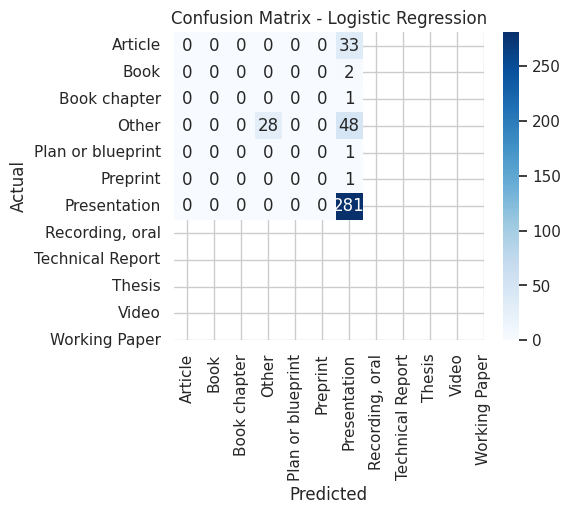

In [ ]:
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

acc_lr = accuracy_score(y_test, y_pred_lr)
print(f"Logistic Regression Accuracy: {acc_lr:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_lr))

cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(5,4))
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues",
            xticklabels=lr_model.classes_,
            yticklabels=lr_model.classes_)
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Random Forest Accuracy: 0.7848
Classification Report:
                  precision    recall  f1-score   support

        Article       0.60      0.09      0.16        33
           Book       0.00      0.00      0.00         2
   Book chapter       0.00      0.00      0.00         1
          Other       0.91      0.41      0.56        76
   Presentation       0.00      0.00      0.00         1
Recording, oral       1.00      1.00      1.00         1
         Thesis       0.78      0.98      0.87       281
          Video       0.00      0.00      0.00         0

       accuracy                           0.78       395
      macro avg       0.41      0.31      0.32       395
   weighted avg       0.78      0.78      0.74       395



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_

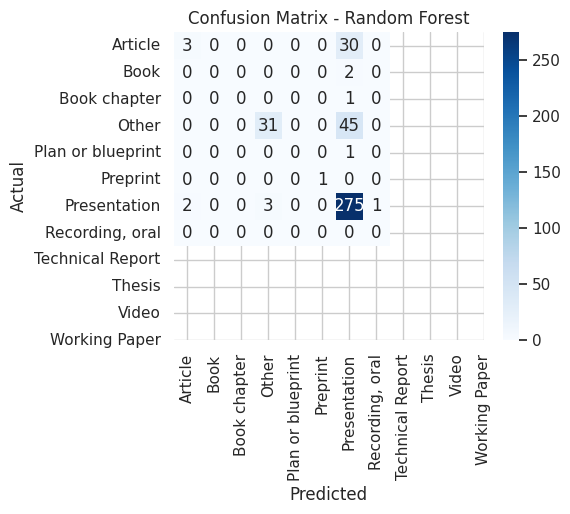

In [ ]:
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

acc_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {acc_rf:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(5,4))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues",
            xticklabels=rf_model.classes_,
            yticklabels=rf_model.classes_)
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

SVM Accuracy: 0.7924
Classification Report:
                  precision    recall  f1-score   support

        Article       0.67      0.06      0.11        33
           Book       0.00      0.00      0.00         2
   Book chapter       0.00      0.00      0.00         1
          Other       0.92      0.43      0.59        76
   Presentation       0.00      0.00      0.00         1
Recording, oral       1.00      1.00      1.00         1
         Thesis       0.78      0.99      0.87       281

       accuracy                           0.79       395
      macro avg       0.48      0.35      0.37       395
   weighted avg       0.79      0.79      0.74       395



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


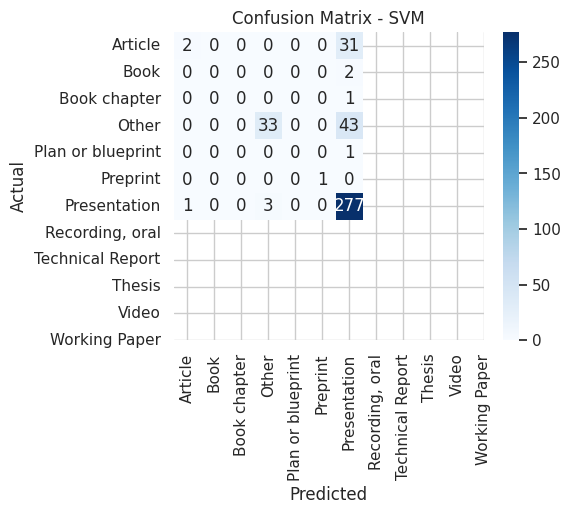

In [ ]:
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

acc_svm = accuracy_score(y_test, y_pred_svm)Mr Kafwaya (Lunte): Madam Speaker, in his response, the hon. Minister referred to compliance with procurement laws regarding stakeholder engagement. It is important for the Government to comply with procurement laws, and if it did, that is good enough. However, a policy shift at the Electoral Commission of Zambia (ECZ) cannot go without stakeholder consultations. Prior to the commission’s commencement of the procurement process, did the ECZ conduct stakeholder consultations for it to determine that the policy it was going to introduce was acceptable to all players?


print(f"SVM Accuracy: {acc_svm:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_svm))

cm_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(5,4))
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Blues",
            xticklabels=svm_model.classes_,
            yticklabels=svm_model.classes_)
plt.title("Confusion Matrix - SVM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Evaluation


##Business Evaluation
Checks whether results meet the business objective (Macro‑F1 ≥ 0.80 on validation).
- Reviews pipeline steps for correctness and consistency (DU → DP → MO → EV → DE).
- Identifies limitations and recommends next steps.
- Saves a structured `evaluation_summary.json` under the project `artifacts/` folder.

In [ ]:
# =============================
# Cell A — Imports & ensure data/splits
# =============================
import os, warnings, pprint
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
import joblib

project_dir = "/content/drive/MyDrive/misc-unza25-csc4792-project_team30"
csv_path = os.path.join(project_dir, "db-unza25-csc4792-datasets-dspace_unza_zm.csv")

# Load df if not present
try:
    df
except NameError:
    df = pd.read_csv(csv_path, delimiter="|")
    print("✅ Loaded df from:", csv_path)

# Ensure expected columns exist
assert "reference" in df.columns and "type" in df.columns, \
    f"Expected columns 'reference' and 'type' in CSV. Found: {df.columns.tolist()}"

# Drop NaNs in core cols and coerce to str
df = df.dropna(subset=["reference", "type"]).copy()
df["reference"] = df["reference"].astype(str)
df["type"] = df["type"].astype(str)

# Create / confirm train/test splits (if not already present)
try:
    X_train, X_test, y_train, y_test
    print("✅ Using existing train/test variables in workspace")
except NameError:
    X = df["reference"]
    y = df["type"]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.20, random_state=42, stratify=y
    )
    print(f"✅ Created train/test split — Train: {len(X_train)} | Test: {len(X_test)}")

# Quick class balance check
print("\nClass distribution (train):")
display(y_train.value_counts())


AssertionError: Expected columns 'reference' and 'type' in CSV. Found: ['reference_text', 'publication_type']


--- Evaluating LogisticRegression ---
Accuracy: 0.5556 | Balanced Acc: 0.2500
Macro P/R/F1: 0.1389 / 0.2500 / 0.1786
Micro P/R/F1: 0.5556 / 0.5556 / 0.5556


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(


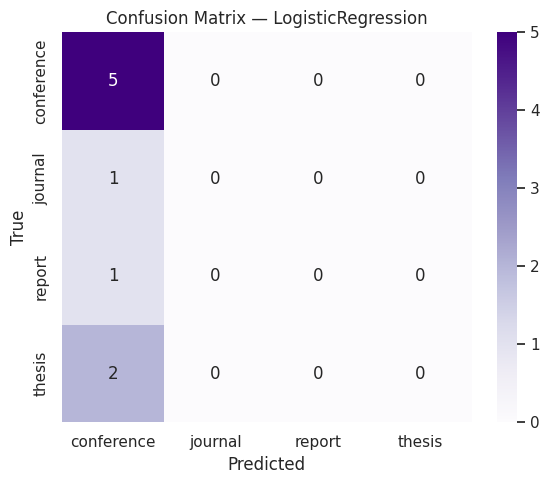


--- Evaluating LinearSVC ---
Accuracy: 0.6667 | Balanced Acc: 0.3750
Macro P/R/F1: 0.4062 / 0.3750 / 0.3590
Micro P/R/F1: 0.6667 / 0.6667 / 0.6667


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(


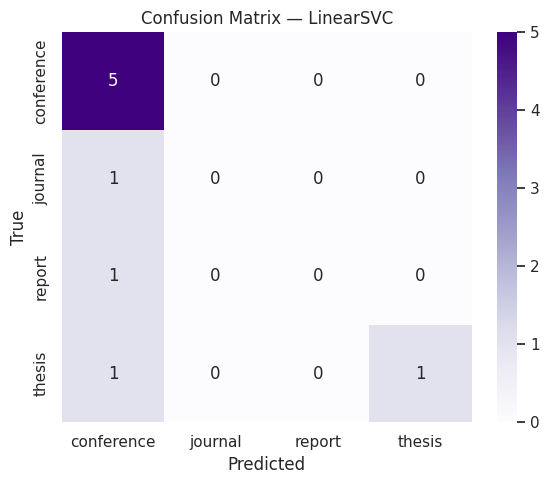


--- Evaluating SVC_RBF ---
Accuracy: 0.3333 | Balanced Acc: 0.2250
Macro P/R/F1: 0.1750 / 0.2250 / 0.1825
Micro P/R/F1: 0.3333 / 0.3333 / 0.3333


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(


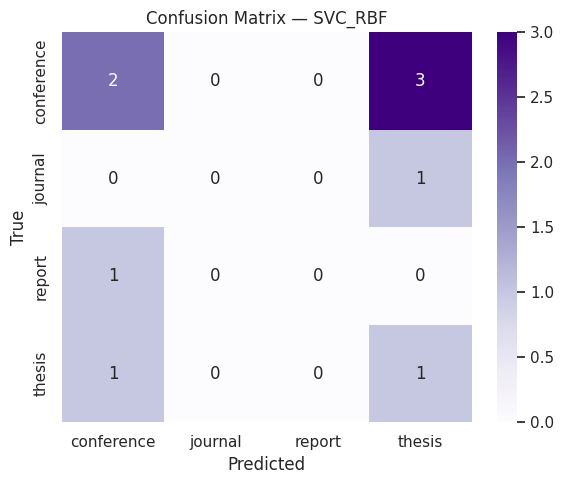


--- Evaluating RandomForest ---


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(


Accuracy: 0.5556 | Balanced Acc: 0.2500
Macro P/R/F1: 0.1389 / 0.2500 / 0.1786
Micro P/R/F1: 0.5556 / 0.5556 / 0.5556


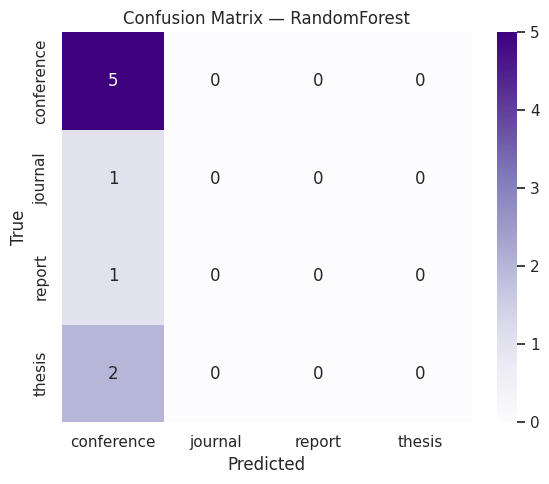


--- Evaluating GradientBoosting ---


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(


Accuracy: 0.3333 | Balanced Acc: 0.2250
Macro P/R/F1: 0.1750 / 0.2250 / 0.1825
Micro P/R/F1: 0.3333 / 0.3333 / 0.3333


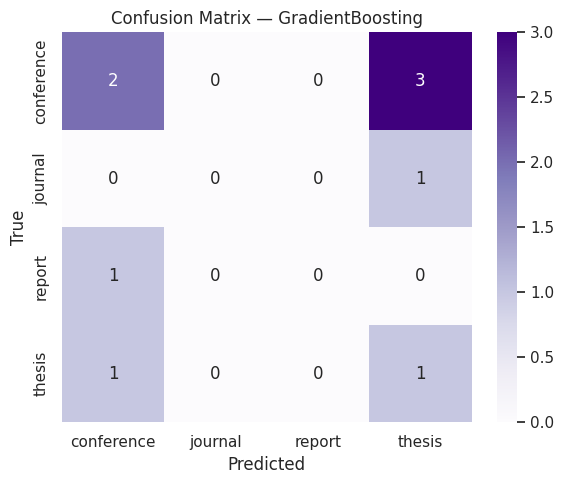


--- Evaluating MultinomialNB ---
Accuracy: 0.5556 | Balanced Acc: 0.2500
Macro P/R/F1: 0.1389 / 0.2500 / 0.1786
Micro P/R/F1: 0.5556 / 0.5556 / 0.5556


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(


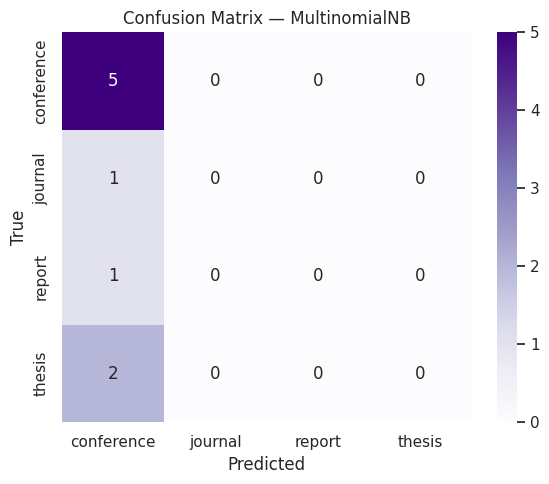


=== Model Comparison Summary ===


,model,accuracy,balanced_accuracy,macro_f1,micro_f1
1,LinearSVC,0.666667,0.375,0.358974,0.666667
2,SVC_RBF,0.333333,0.225,0.182540,0.333333
4,GradientBoosting,0.333333,0.225,0.182540,0.333333
0,LogisticRegression,0.555556,0.250,0.178571,0.555556
3,RandomForest,0.555556,0.250,0.178571,0.555556
5,MultinomialNB,0.555556,0.250,0.178571,0.555556


Saved evaluation summary CSV: /content/drive/MyDrive/misc-unza25-csc4792-project_team30/data/model_evaluation_summary.csv

=== Detailed Evaluation for Best Full Pipeline ===
Accuracy: 0.6667 | Balanced Accuracy: 0.3750


,precision,recall,f1-score,support
conference,0.625,1.0,0.769231,5.0
journal,0.000,0.0,0.000000,1.0
report,0.000,0.0,0.000000,1.0
thesis,1.000,0.5,0.666667,2.0



Sample misclassifications (up to 10): 3
- True: report | Pred: conference | Text: enterprise medical imaging for streamlined radiological diagnosis in zambian public health facilities...
- True: journal | Pred: conference | Text: automatic classification of digital objects for improved metadata quality of electronic theses and dissertations in institutional repositori...
- True: thesis | Pred: conference | Text: simple digital libraries...


In [ ]:
# ==========================
# Full Evaluation — All Models + Detailed Metrics (updated)
# ==========================
import os, re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MaxAbsScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_recall_fscore_support,
    balanced_accuracy_score,
)

# --------------------------
# Ensure validation split exists
# --------------------------
required_vars = ['X_train_df', 'X_val_df', 'y_train_df', 'y_val_df']
if any(v not in globals() for v in required_vars):
    raise RuntimeError("Validation split not found. Re-run Full Modeling to define X_train_df/X_val_df/y_*.")

# --------------------------
# Rebuild preprocess if not present (derive from X_train_df)
# --------------------------
if 'preprocess' not in globals():
    text_col = X_train_df.columns[0]
    numeric_cols = [c for c in X_train_df.columns if c != text_col]

    text_preprocess = Pipeline([
        ('fillna', FunctionTransformer(lambda s: s.fillna(''), validate=False)),
        ('tfidf', TfidfVectorizer(ngram_range=(1,2), max_features=20000, min_df=1)),
    ])
    num_preprocess = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
        ('scaler', MaxAbsScaler()),
    ])
    preprocess = ColumnTransformer([
        ('text', text_preprocess, text_col),
        ('num', num_preprocess, numeric_cols),
    ])

# --------------------------
# Models to evaluate (dense-safe)
# --------------------------
noop = FunctionTransformer(lambda X: X, accept_sparse=True)
to_dense = FunctionTransformer(lambda X: X.toarray() if hasattr(X, "toarray") else X, accept_sparse=True)

models = {
    'LogisticRegression': {'est': LogisticRegression(max_iter=2000, solver='liblinear', class_weight='balanced'), 'dense': False},
    'LinearSVC':         {'est': LinearSVC(C=1.0, class_weight='balanced', max_iter=5000),                      'dense': False},
    'SVC_RBF':           {'est': SVC(kernel='rbf', C=1.0, gamma='scale', class_weight='balanced'),              'dense': True},
    'RandomForest':      {'est': RandomForestClassifier(n_estimators=300, class_weight='balanced', random_state=42, n_jobs=-1), 'dense': True},
    'GradientBoosting':  {'est': GradientBoostingClassifier(n_estimators=300, random_state=42),                 'dense': True},
    'MultinomialNB':     {'est': MultinomialNB(),                                                               'dense': False}
}

evaluation_results = []

for name, spec in models.items():
    print(f"\n--- Evaluating {name} ---")

    densifier = to_dense if spec['dense'] else noop
    pipe = Pipeline([
        ('prep', preprocess),   # reuse/rebuild ColumnTransformer
        ('to_dense', densifier),
        ('clf', spec['est'])
    ])

    pipe.fit(X_train_df, y_train_df)
    y_pred = pipe.predict(X_val_df)

    acc = accuracy_score(y_val_df, y_pred)
    bal_acc = balanced_accuracy_score(y_val_df, y_pred)
    report_dict = classification_report(y_val_df, y_pred, output_dict=True, zero_division=0)

    macro_p = report_dict['macro avg']['precision']
    macro_r = report_dict['macro avg']['recall']
    macro_f1 = report_dict['macro avg']['f1-score']
    micro_p, micro_r, micro_f1, _ = precision_recall_fscore_support(y_val_df, y_pred, average='micro', zero_division=0)

    evaluation_results.append({
        'model': name,
        'accuracy': acc,
        'balanced_accuracy': bal_acc,
        'macro_f1': macro_f1,
        'micro_f1': micro_f1
    })

    print(f"Accuracy: {acc:.4f} | Balanced Acc: {bal_acc:.4f}")
    print(f"Macro P/R/F1: {macro_p:.4f} / {macro_r:.4f} / {macro_f1:.4f}")
    print(f"Micro P/R/F1: {micro_p:.4f} / {micro_r:.4f} / {micro_f1:.4f}")

    # Confusion Matrix
    labels_sorted = sorted(pd.unique(pd.Series(y_val_df)))
    cm = confusion_matrix(y_val_df, y_pred, labels=labels_sorted)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=labels_sorted, yticklabels=labels_sorted)
    plt.title(f'Confusion Matrix — {name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

# --------------------------
# Compile all evaluation results
# --------------------------
eval_df = pd.DataFrame(evaluation_results).sort_values(by='macro_f1', ascending=False)
print("\n=== Model Comparison Summary ===")
display(eval_df)

# Save to CSV
if 'project_dir' in globals() and os.path.isdir(project_dir):
    out_eval_csv = os.path.join(project_dir, 'data', 'model_evaluation_summary.csv')
    eval_df.to_csv(out_eval_csv, index=False)
    print(f"Saved evaluation summary CSV: {out_eval_csv}")

# --------------------------
# Diagnostics for best_full_pipeline (if available)
# --------------------------
if 'best_full_pipeline' in globals():
    print("\n=== Detailed Evaluation for Best Full Pipeline ===")
    y_pred = best_full_pipeline.predict(X_val_df)
    acc = accuracy_score(y_val_df, y_pred)
    bal_acc = balanced_accuracy_score(y_val_df, y_pred)
    report_dict = classification_report(y_val_df, y_pred, output_dict=True, zero_division=0)

    print(f"Accuracy: {acc:.4f} | Balanced Accuracy: {bal_acc:.4f}")

    per_class = pd.DataFrame(report_dict).T
    per_class = per_class.loc[[c for c in per_class.index if c not in ['accuracy','macro avg','weighted avg']]].sort_index()
    display(per_class)

    # Misclassifications
    val_true = pd.Series(y_val_df)
    mis_idx = np.where(y_pred != val_true.values)[0]
    print(f"\nSample misclassifications (up to 10): {min(10, len(mis_idx))}")
    for i in mis_idx[:10]:
        try:
            text = X_val_df.iloc[i][X_val_df.columns[0]] if hasattr(X_val_df, 'iloc') else str(X_val_df[i])
        except Exception:
            text = str(X_val_df)
        print(f"- True: {val_true.iloc[i]} | Pred: {y_pred[i]} | Text: {text[:140]}...")

In [ ]:
# ==========================
# Deployment Stage — PDF Bitstream Integration (UNZA Repository)
# ==========================
import os
import joblib
import requests
import PyPDF2
from io import BytesIO
from sickle import Sickle
from sklearn.pipeline import Pipeline

# ---- Setup ----
project_dir = "/content/drive/MyDrive/misc-unza25-csc4792-project_team30/"
os.makedirs(project_dir, exist_ok=True)

# Load best model + vectorizer (SVM chosen earlier)
model = joblib.load(os.path.join(project_dir, "final_model.pkl"))
vectorizer = joblib.load(os.path.join(project_dir, "tfidf_vectorizer.pkl"))

# Create pipeline
pipeline = Pipeline([
    ('tfidf', vectorizer),
    ('clf', model)
])

# ---- Connect to OAI-PMH feed (UNZA DSpace endpoint) ----
sickle = Sickle("https://dspace.unza.zm/server/oai/request")

records = sickle.ListRecords(metadataPrefix="oai_dc", set=None)

print("🔎 Fetching repository PDF bitstreams and classifying...\n")

def extract_pdf_text(pdf_bytes):
    """Extract raw text from PDF bytes"""
    text = ""
    try:
        reader = PyPDF2.PdfReader(BytesIO(pdf_bytes))
        for page in reader.pages[:5]:  # limit to first 5 pages for demo
            text += page.extract_text() or ""
    except Exception as e:
        print(f"⚠️ PDF extraction error: {e}")
    return text.strip()

# ---- Run predictions on first few PDFs ----
count = 0
for record in records:
    metadata = record.metadata
    identifiers = metadata.get("identifier", [])

    # Look for PDF links in identifiers
    pdf_links = [id_ for id_ in identifiers if id_.endswith(".pdf")]
    if not pdf_links:
        continue

    pdf_url = pdf_links[0]
    try:
        # Download the PDF bitstream
        response = requests.get(pdf_url, timeout=20)
        if response.status_code == 200:
            pdf_text = extract_pdf_text(response.content)

            if pdf_text:
                # Predict with trained pipeline
                prediction = pipeline.predict([pdf_text])[0]

                print(f"📄 {metadata.get('title', ['Untitled'])[0]}")
                print(f"   URL: {pdf_url}")
                print(f"   → Predicted Category: {prediction}\n")

                count += 1
                if count >= 3:  # show 3 for demo
                    break
    except Exception as e:
        print(f"⚠️ Could not process {pdf_url}: {e}")


Choose an option:
1. Run Demo (default demo PDF)
2. Enter your own Bitstream URL
